In [1]:
from konlpy.tag import Mecab
from collections import Counter

import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
class ClassifierModel():
    def __init__(self, datasets=[{ 'name': 'preprocessed_train', 'frac': 1 }]):
        super(ClassifierModel, self).__init__()
        
        self.tokenizer = Mecab()
        self.stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
        
        self.vocab_size = None
        self.word_vector_dim = 128
        
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.x_val = None
        self.y_val = None
        
        self.preprocess(datasets)
        
        self.model = self.CNN()
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    
    def data_load(self, datasets):
        
        _dir = '../../data'
        
        trains = []
        vals = []
        tests = []
        
        for it in datasets:
            _df = pd.read_csv(f'{_dir}/{it["name"]}.csv')
            
            _train = _df[:int(len(_df)*0.6)]
            _val = _df[int(len(_df)*0.6):int(len(_df)*0.8)]
            _test = _df[int(len(_df)*0.8):]
            
            if it["name"] == 'preprocessed_train':
                vals.append(_val)
                tests.append(_test)
            else:
                _train = _train.sample(frac=it['frac'])
                
            trains.append(_train)
            
        train = pd.concat(trains)
        train.drop_duplicates(inplace=True)
        val = pd.concat(vals)
        val.drop_duplicates(inplace=True)
        test = pd.concat(tests)
        test.drop_duplicates(inplace=True)
        
        return train, val, test
    

    def preprocess_sentence(self, sentence):

        sentence = sentence.lower().strip()
        sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
        sentence = re.sub(r'[" "]+', " ", sentence)
        sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)
        sentence = sentence.strip()

        return sentence
    
    
    def tokenize(self, it):
        result = []
        for sentence in it:
            temp = self.tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in self.stopwords] 
            result.append(temp)
        return result
    
    
    def pad_sequences(self, it, word_to_index):
        return tf.keras.preprocessing.sequence.pad_sequences(
            it, value=word_to_index["<PAD>"], padding='pre', maxlen=70)
    
    
    def preprocess(self, datasets):
        
        train, val, test = self.data_load(datasets)

        train['data'] = train['data'].apply(lambda it : self.preprocess_sentence(it))
        val['data'] = val['data'].apply(lambda it : self.preprocess_sentence(it))
        test['data'] = test['data'].apply(lambda it : self.preprocess_sentence(it))
        
        
        x_train = self.tokenize(train['data'])
        x_test = self.tokenize(test['data'])
        x_val = self.tokenize(val['data'])
        
        self.y_train = tf.keras.utils.to_categorical(train['label'], num_classes=4, dtype='float32')
        self.y_val = tf.keras.utils.to_categorical(val['label'], num_classes=4, dtype='float32')
        self.y_test = tf.keras.utils.to_categorical(test['label'], num_classes=4, dtype='float32')
        
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(10000-4)
        vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
        word_to_index = { word:index for index, word in enumerate(vocab) }
        
        self.vocab_size = len(word_to_index)
        
        def wordlist_to_index_list(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
        x_train = list(map(wordlist_to_index_list, x_train))
        x_test = list(map(wordlist_to_index_list, x_test))
        x_val = list(map(wordlist_to_index_list, x_val))  
        
        self.x_train = self.pad_sequences(x_train, word_to_index)
        self.x_val = self.pad_sequences(x_val, word_to_index)
        self.x_test = self.pad_sequences(x_test, word_to_index)
    

    def CNN(self):
    
        inputs = Input(shape=(None, ))
        embedding = Embedding(self.vocab_size, self.word_vector_dim)(inputs)

        branches = []
        for filter_size in [3, 3]:
            branch = Conv1D(64, filter_size, activation='relu')(embedding)
            branch = GlobalMaxPooling1D()(branch)
            branches.append(branch)

        out = Concatenate()(branches)
        out = Dense(32, activation='relu')(out)
        out = Dropout(0.5)(out)

        out = Dense(4, activation='softmax')(out)
        model = Model(inputs=inputs, outputs=out)

        return model
    
    def train(self):
        self.history = self.model.fit(
            self.x_train, self.y_train, epochs=20, batch_size=64,
            validation_data=(self.x_val, self.y_val), callbacks=self.es, verbose=1)
        
    def show_report(self):
        y_pred = self.model.predict(self.x_test).argmax(axis=1)
        y_true = self.y_test.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3147 - accuracy: 0.4026 - val_loss: 1.1281 - val_accuracy: 0.6215
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9558 - accuracy: 0.6304 - val_loss: 0.7260 - val_accuracy: 0.7595
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5699 - accuracy: 0.8083 - val_loss: 0.5372 - val_accuracy: 0.8063
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3313 - accuracy: 0.9045 - val_loss: 0.4830 - val_accuracy: 0.8291
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1880 - accuracy: 0.9525 - val_loss: 0.4930 - val_accuracy: 0.8342
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1215 - accuracy: 0.9696 - val_loss: 0.4987 - val_accuracy: 0.8418
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9800 - val_loss: 0.5180 - val_accuracy: 0.8405
Epoch 8/20
65/65 [==

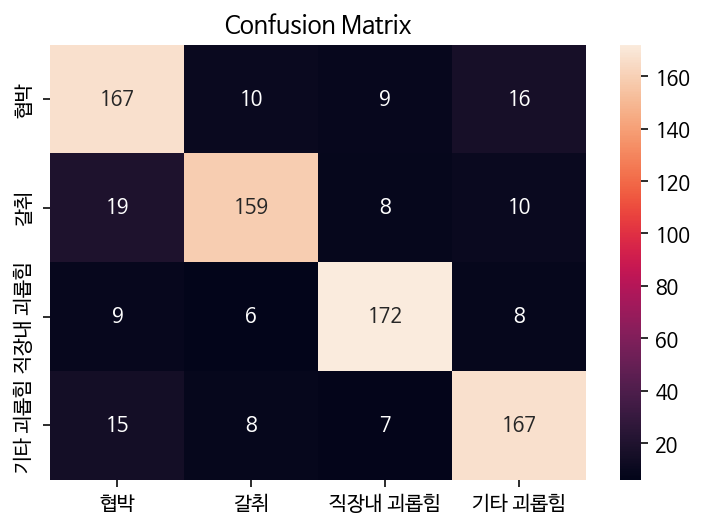

In [8]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 0.4 },
    { 'name': 'train_rd', 'frac': 0.35 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.2931 - accuracy: 0.4279 - val_loss: 1.0764 - val_accuracy: 0.6228
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9461 - accuracy: 0.6557 - val_loss: 0.7234 - val_accuracy: 0.7709
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5927 - accuracy: 0.7999 - val_loss: 0.5360 - val_accuracy: 0.8152
Epoch 4/20
65/65 [==============================] - 0s 6ms/step - loss: 0.3840 - accuracy: 0.8824 - val_loss: 0.4699 - val_accuracy: 0.8316
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2266 - accuracy: 0.9429 - val_loss: 0.4470 - val_accuracy: 0.8430
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1424 - accuracy: 0.9636 - val_loss: 0.4633 - val_accuracy: 0.8506
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0971 - accuracy: 0.9769 - val_loss: 0.4836 - val_accuracy: 0.8468
Epoch 8/20
65/65 [==

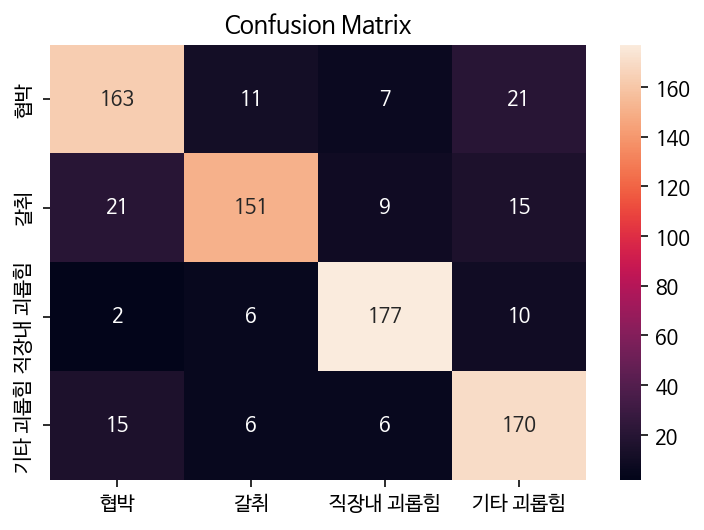

In [9]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 0.4 },
    { 'name': 'train_bt_en', 'frac': 0.35 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3103 - accuracy: 0.4028 - val_loss: 1.1134 - val_accuracy: 0.6873
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.8906 - accuracy: 0.6813 - val_loss: 0.6679 - val_accuracy: 0.7810
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5582 - accuracy: 0.8170 - val_loss: 0.5462 - val_accuracy: 0.8076
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3432 - accuracy: 0.9012 - val_loss: 0.5083 - val_accuracy: 0.8165
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1978 - accuracy: 0.9494 - val_loss: 0.5007 - val_accuracy: 0.8266
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1168 - accuracy: 0.9752 - val_loss: 0.5047 - val_accuracy: 0.8354
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0812 - accuracy: 0.9836 - val_loss: 0.5576 - val_accuracy: 0.8215
Epoch 8/20
65/65 [==

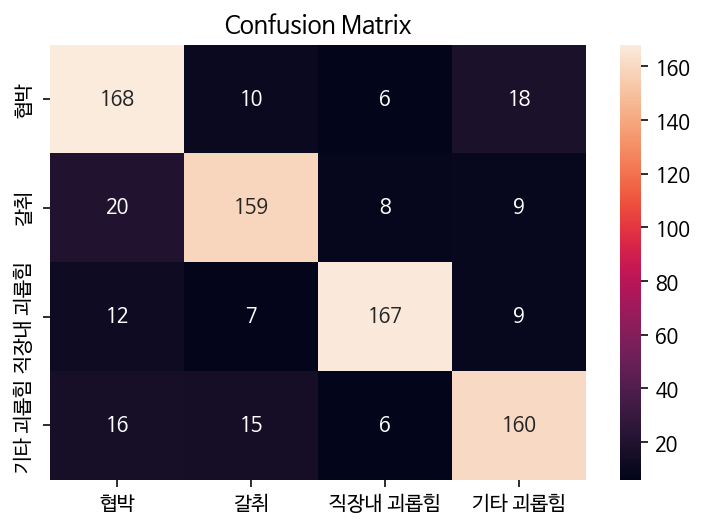

In [10]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 0.4 },
    { 'name': 'train_bt_ja', 'frac': 0.35 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3061 - accuracy: 0.3975 - val_loss: 1.1199 - val_accuracy: 0.5987
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9305 - accuracy: 0.6430 - val_loss: 0.7123 - val_accuracy: 0.7633
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5817 - accuracy: 0.8093 - val_loss: 0.5240 - val_accuracy: 0.8127
Epoch 4/20
65/65 [==============================] - 0s 6ms/step - loss: 0.3475 - accuracy: 0.9009 - val_loss: 0.4791 - val_accuracy: 0.8177
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2081 - accuracy: 0.9489 - val_loss: 0.4794 - val_accuracy: 0.8190
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1266 - accuracy: 0.9706 - val_loss: 0.5003 - val_accuracy: 0.8190
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0817 - accuracy: 0.9819 - val_loss: 0.5215 - val_accuracy: 0.8165
Epoch 8/20
65/65 [==

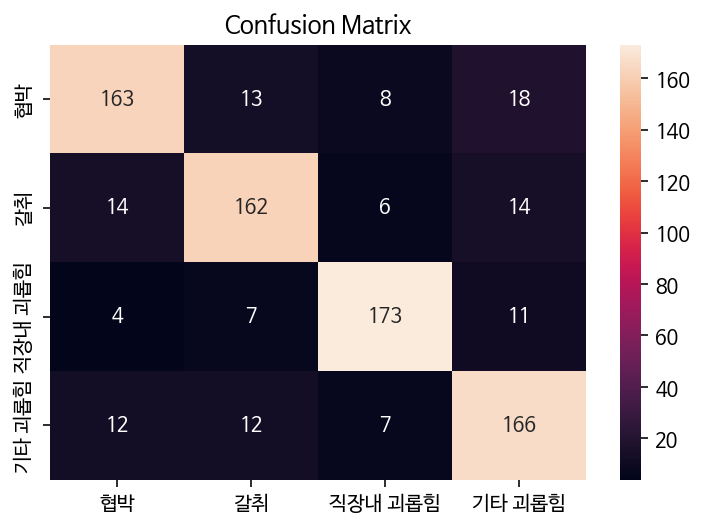

In [11]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 0.4 },
    { 'name': 'train_bt_en', 'frac': 0.35 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3182 - accuracy: 0.3961 - val_loss: 1.1514 - val_accuracy: 0.6557
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9641 - accuracy: 0.6205 - val_loss: 0.7374 - val_accuracy: 0.7646
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.6491 - accuracy: 0.7763 - val_loss: 0.5705 - val_accuracy: 0.7975
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.4309 - accuracy: 0.8597 - val_loss: 0.5263 - val_accuracy: 0.8152
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2812 - accuracy: 0.9209 - val_loss: 0.5395 - val_accuracy: 0.8190
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1805 - accuracy: 0.9568 - val_loss: 0.5231 - val_accuracy: 0.8304
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1167 - accuracy: 0.9684 - val_loss: 0.5507 - val_accuracy: 0.8342
Epoch 8/20
65/65 [==

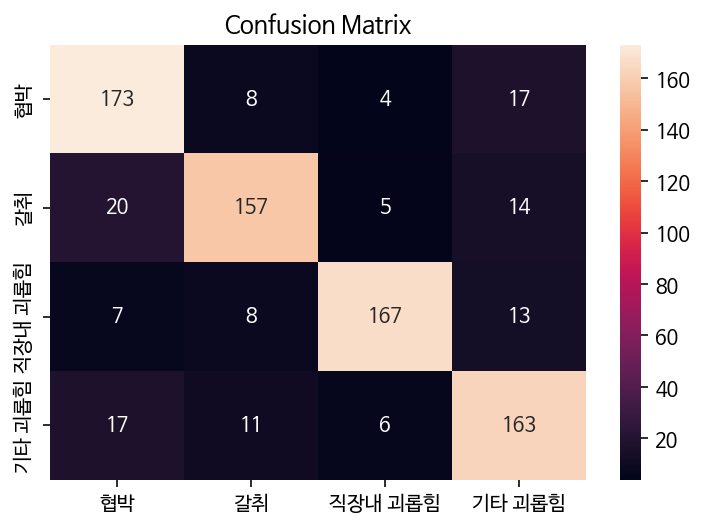

In [12]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 0.4 },
    { 'name': 'train_bt_ja', 'frac': 0.35 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3119 - accuracy: 0.4014 - val_loss: 1.1219 - val_accuracy: 0.6684
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9544 - accuracy: 0.6466 - val_loss: 0.7182 - val_accuracy: 0.7671
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.6293 - accuracy: 0.7871 - val_loss: 0.5556 - val_accuracy: 0.8076
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.4280 - accuracy: 0.8664 - val_loss: 0.5122 - val_accuracy: 0.8203
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2904 - accuracy: 0.9144 - val_loss: 0.4906 - val_accuracy: 0.8266
Epoch 6/20
65/65 [==============================] - 0s 6ms/step - loss: 0.1820 - accuracy: 0.9537 - val_loss: 0.4822 - val_accuracy: 0.8380
Epoch 7/20
65/65 [==============================] - 0s 6ms/step - loss: 0.1329 - accuracy: 0.9650 - val_loss: 0.4902 - val_accuracy: 0.8481
Epoch 8/20
65/65 [==

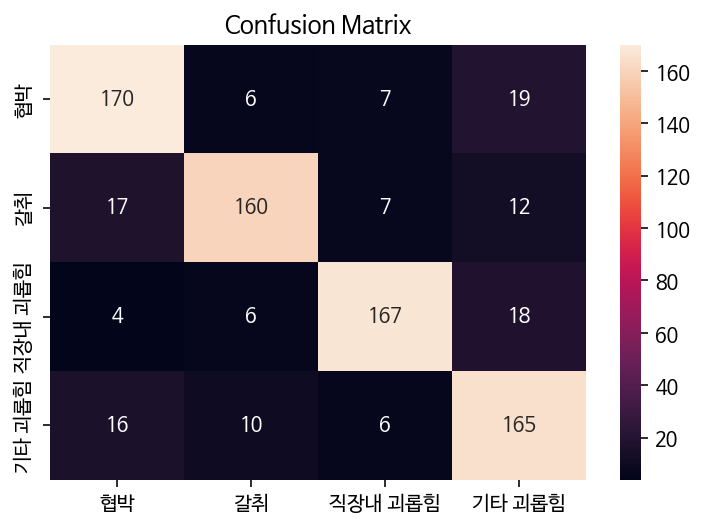

In [13]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_bt_en', 'frac': 0.4 },
    { 'name': 'train_bt_ja', 'frac': 0.35 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 12ms/step - loss: 1.3324 - accuracy: 0.3865 - val_loss: 1.1833 - val_accuracy: 0.6899
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9735 - accuracy: 0.6368 - val_loss: 0.7086 - val_accuracy: 0.7797
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.6111 - accuracy: 0.7982 - val_loss: 0.5455 - val_accuracy: 0.8025
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.4011 - accuracy: 0.8802 - val_loss: 0.5114 - val_accuracy: 0.8316
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2440 - accuracy: 0.9380 - val_loss: 0.4885 - val_accuracy: 0.8430
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1599 - accuracy: 0.9617 - val_loss: 0.5145 - val_accuracy: 0.8456
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1061 - accuracy: 0.9766 - val_loss: 0.5409 - val_accuracy: 0.8506
Epoch 8/20
65/65 [=

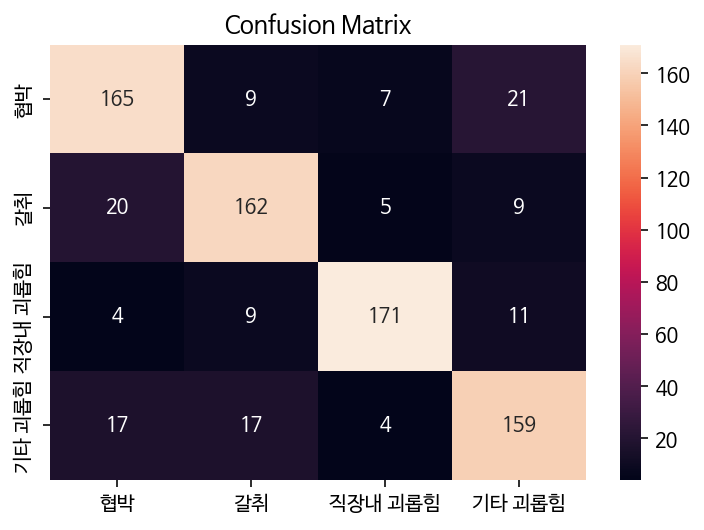

In [14]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 0.3 },
    { 'name': 'train_rd', 'frac': 0.25 },
    { 'name': 'train_bt_en', 'frac': 0.2 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3314 - accuracy: 0.3764 - val_loss: 1.1730 - val_accuracy: 0.7076
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9660 - accuracy: 0.6448 - val_loss: 0.7272 - val_accuracy: 0.7620
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.6295 - accuracy: 0.7798 - val_loss: 0.5806 - val_accuracy: 0.7975
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3983 - accuracy: 0.8799 - val_loss: 0.5170 - val_accuracy: 0.8190
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2347 - accuracy: 0.9363 - val_loss: 0.4943 - val_accuracy: 0.8203
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1379 - accuracy: 0.9720 - val_loss: 0.5293 - val_accuracy: 0.8316
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0931 - accuracy: 0.9783 - val_loss: 0.5780 - val_accuracy: 0.8228
Epoch 8/20
65/65 [==

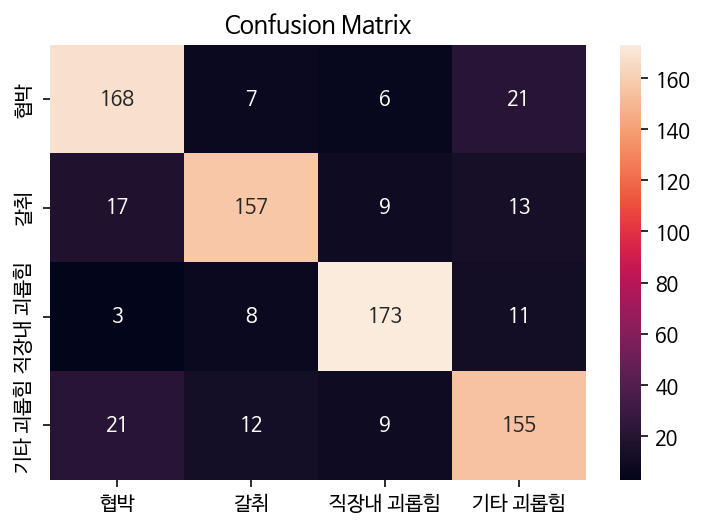

In [15]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 0.3 },
    { 'name': 'train_rd', 'frac': 0.25 },
    { 'name': 'train_bt_ja', 'frac': 0.2 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3118 - accuracy: 0.3964 - val_loss: 1.1181 - val_accuracy: 0.6253
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9830 - accuracy: 0.6245 - val_loss: 0.7356 - val_accuracy: 0.7494
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.6273 - accuracy: 0.7914 - val_loss: 0.5535 - val_accuracy: 0.7987
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.4014 - accuracy: 0.8717 - val_loss: 0.5114 - val_accuracy: 0.8152
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2597 - accuracy: 0.9339 - val_loss: 0.4888 - val_accuracy: 0.8304
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1593 - accuracy: 0.9636 - val_loss: 0.5141 - val_accuracy: 0.8253
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1141 - accuracy: 0.9720 - val_loss: 0.5184 - val_accuracy: 0.8291
Epoch 8/20
65/65 [==

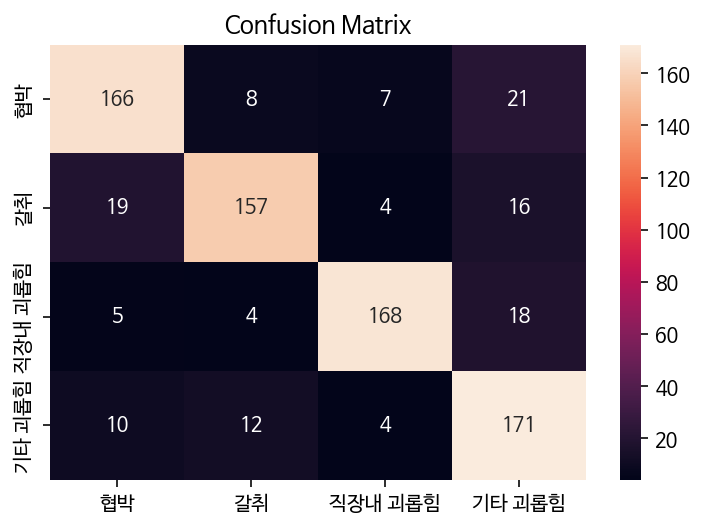

In [16]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rd', 'frac': 0.3 },
    { 'name': 'train_bt_en', 'frac': 0.25 },
    { 'name': 'train_bt_ja', 'frac': 0.2 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()

Epoch 1/20
65/65 [==============================] - 1s 8ms/step - loss: 1.3209 - accuracy: 0.3795 - val_loss: 1.1563 - val_accuracy: 0.6253
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.9463 - accuracy: 0.6519 - val_loss: 0.6874 - val_accuracy: 0.7709
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.5721 - accuracy: 0.8069 - val_loss: 0.5139 - val_accuracy: 0.8203
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.3376 - accuracy: 0.9079 - val_loss: 0.4807 - val_accuracy: 0.8291
Epoch 5/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1934 - accuracy: 0.9573 - val_loss: 0.4767 - val_accuracy: 0.8329
Epoch 6/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1236 - accuracy: 0.9740 - val_loss: 0.4864 - val_accuracy: 0.8481
Epoch 7/20
65/65 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.9853 - val_loss: 0.5215 - val_accuracy: 0.8494
Epoch 8/20
65/65 [==

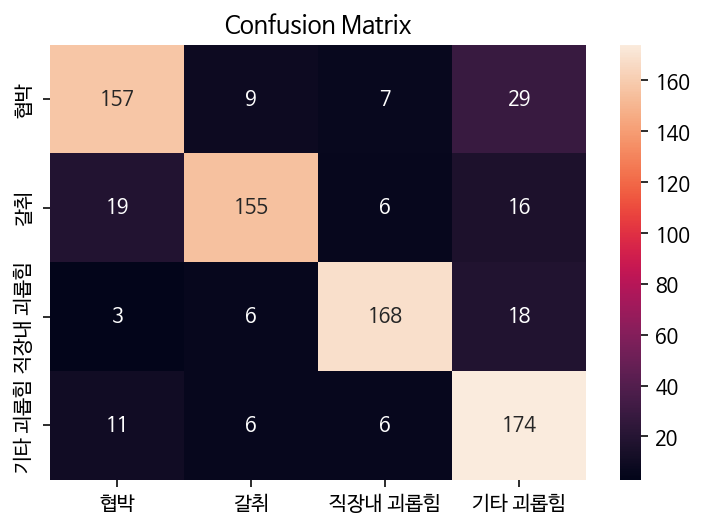

In [17]:
datasets = [
    { 'name': 'preprocessed_train', 'frac': 1 },
    { 'name': 'train_rs', 'frac': 0.2 },
    { 'name': 'train_rd', 'frac': 0.2 },
    { 'name': 'train_bt_en', 'frac': 0.2 },
    { 'name': 'train_bt_ja', 'frac': 0.15 }
]
model = ClassifierModel(datasets=datasets)
model.train()
model.show_report()